In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..

/home/suetin/Projects/VSCode/TennisApp/MainApp/TennisApp


In [3]:
# read the picle file
with open('data/temporary/ball_detections.pkl', 'rb') as f:  # /home/suetin/Projects/VSCode/TennisApp/MainApp/TennisApp/data/temporary/ball_detections.pkl
    ball_positions = pickle.load(f)

In [4]:
ball_positions[:3]

[(707, 333), (707, 333), (707, 333)]

In [5]:
# convert the list into pandas.DataFrame
df_ball_positions = pd.DataFrame(np.array(ball_positions), columns=['x', 'y'], dtype=float)
# interpolate the missing values
print(df_ball_positions.isna().sum())
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()
print(df_ball_positions.isna().sum())

# # Convert pandas.DataFrame to original format. Back up
# ball_positions = df_ball_positions.astype(int).tolist()  # .to_numpy()
# ball_positions

x    0
y    0
dtype: int64
x    0
y    0
dtype: int64


In [6]:
# MA 
df_ball_positions['y_ma'] = df_ball_positions['y'].rolling(window=5, min_periods=1, center=False).mean()
df_ball_positions['x_ma'] = df_ball_positions['x'].rolling(window=5, min_periods=1, center=False).mean()
df_ball_positions.sample(5)

,x,y,y_ma,x_ma
235,455.0,228.0,218.4,235.8
228,465.0,262.0,244.6,459.2
257,409.0,117.0,124.8,329.4
281,407.0,90.0,285.2,646.2
176,6.0,177.0,177.0,6.0


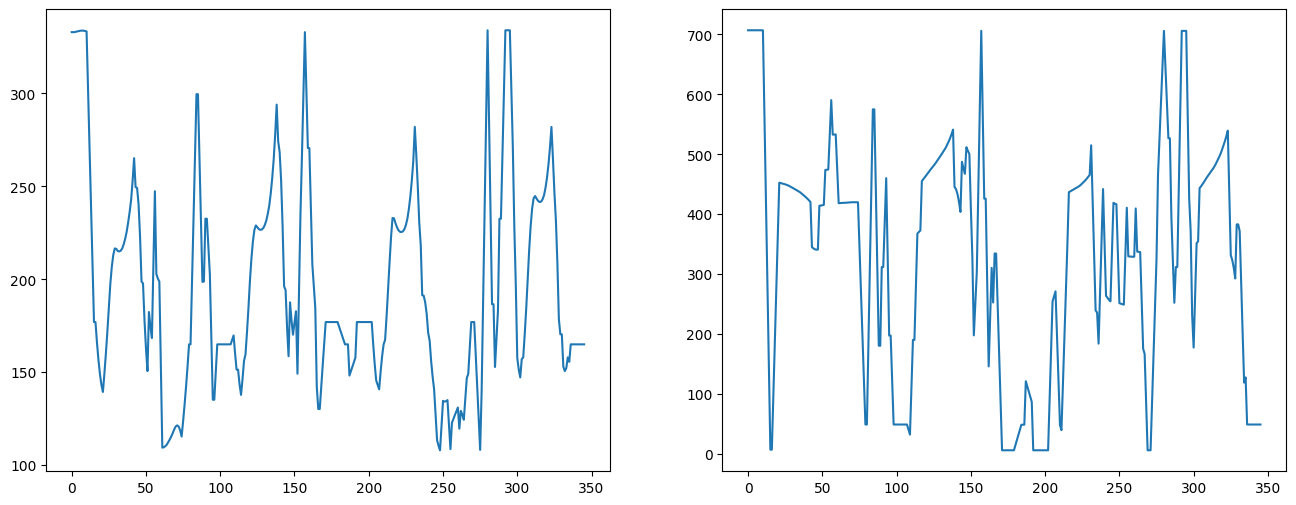

In [7]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(df_ball_positions['y_ma'])
plt.subplot(1, 2, 2)
plt.plot(df_ball_positions['x_ma'])

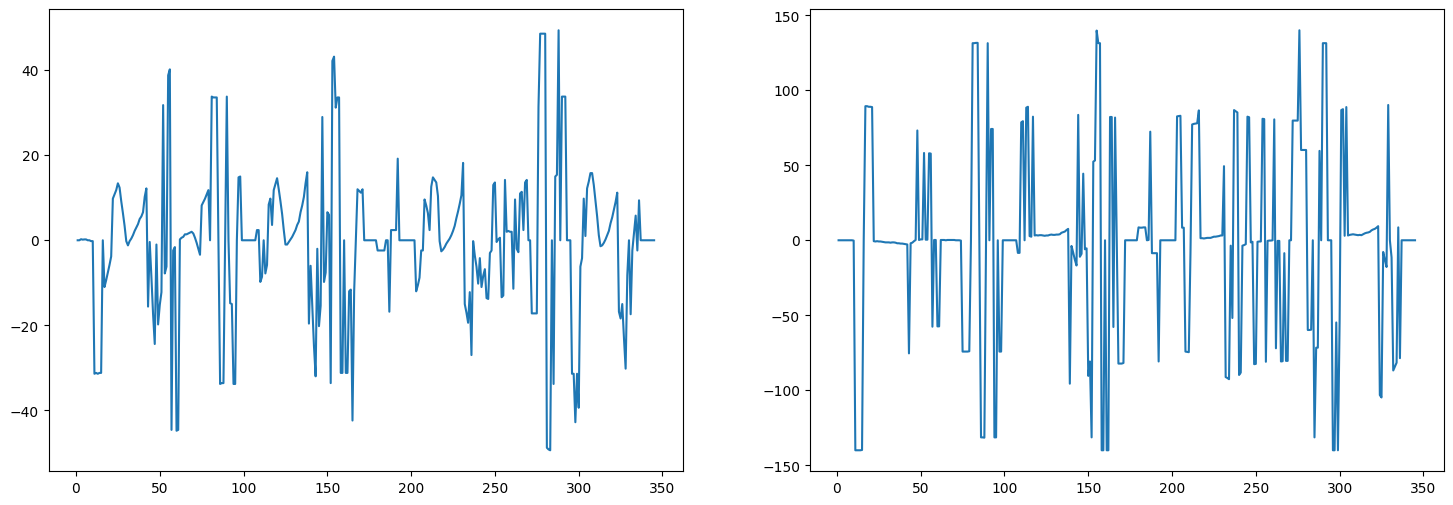

In [20]:
df_ball_positions['delta_y'] = df_ball_positions['y_ma'].diff()
df_ball_positions['delta_x'] = df_ball_positions['x_ma'].diff()


plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(df_ball_positions['delta_y'])
plt.subplot(1, 2, 2)
plt.plot(df_ball_positions['delta_x'])

In [9]:
df_ball_positions['ball_hit'] = 0


minimum_change_frames_for_hit = 25

for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count > minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1


frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()
df_ball_positions[df_ball_positions['ball_hit']==1]

,x,y,y_ma,x_ma,delta_y,ball_hit


## Hits the ball

In [26]:
df_ball_positions['y_ma_shifted'] = df_ball_positions['y_ma'].shift(-1)
df_ball_positions['x_ma_shifted'] = df_ball_positions['x_ma'].shift(1)
df_ball_positions.fillna(0, inplace=True)
df_ball_positions.tail(20)

,x,y,y_ma,x_ma,delta_y,ball_hit,delta_x,y_ma_shifted,x_ma_shifted
326,499.0,205.0,231.8,323.6,-15.0,0,-7.8,208.8,331.4
327,483.0,177.0,208.8,310.6,-23.0,0,-13.0,178.6,323.6
328,470.0,157.0,178.6,292.8,-30.2,0,-17.8,170.4,310.6
329,457.0,136.0,170.4,383.0,-8.2,0,90.2,170.4,292.8
330,6.0,177.0,170.4,383.0,0.0,0,0.0,153.0,383.0
331,442.0,118.0,153.0,371.6,-17.4,0,-11.4,150.6,383.0
332,49.0,165.0,150.6,284.8,-2.4,0,-86.8,152.2,371.6
333,49.0,165.0,152.2,200.6,1.6,0,-84.2,158.0,284.8
334,49.0,165.0,158.0,119.0,5.8,0,-81.6,155.6,200.6
335,49.0,165.0,155.6,127.6,-2.4,0,8.6,165.0,119.0


In [30]:
from scipy.spatial import distance

def measure_distance(p1, p2):
    """
    p1 - player_center
    p2 - court_keypoint
    """
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

In [35]:
df_ball_positions[['x_ma', 'y_ma']]

array([        707,         333])

In [36]:
df_ball_positions['distance'] = ((df_ball_positions['x_ma'] - df_ball_positions['x_ma_shifted'])**2 \
                                + (df_ball_positions['y_ma'] - df_ball_positions['y_ma_shifted'])**2) 
                                                 
df_ball_positions

,x,y,y_ma,x_ma,delta_y,ball_hit,delta_x,y_ma_shifted,x_ma_shifted,distance
0,707.0,333.0,333.00,707.0,0.00,0,0.0,333.00,0.0,499849.0000
1,707.0,333.0,333.00,707.0,0.00,0,0.0,333.00,707.0,0.0000
2,707.0,333.0,333.00,707.0,0.00,0,0.0,333.25,707.0,0.0625
3,707.0,334.0,333.25,707.0,0.25,0,0.0,333.40,707.0,0.0225
4,707.0,334.0,333.40,707.0,0.15,0,0.0,333.60,707.0,0.0400
...,...,...,...,...,...,...,...,...,...,...
341,49.0,165.0,165.00,49.0,0.00,0,0.0,165.00,49.0,0.0000
342,49.0,165.0,165.00,49.0,0.00,0,0.0,165.00,49.0,0.0000
343,49.0,165.0,165.00,49.0,0.00,0,0.0,165.00,49.0,0.0000
344,49.0,165.0,165.00,49.0,0.00,0,0.0,165.00,49.0,0.0000


In [45]:
df_ball_positions['x_norm'] = (df_ball_positions['x'] - df_ball_positions['x'].min()) / (df_ball_positions['x'].max() - df_ball_positions['x'].min())
df_ball_positions['y_norm'] = (df_ball_positions['y'] - df_ball_positions['y'].min()) / (df_ball_positions['y'].max() - df_ball_positions['y'].min())
df_ball_positions.sample(5)

,x,y,y_ma,x_ma,delta_y,ball_hit,delta_x,y_ma_shifted,x_ma_shifted,distance,x_norm,y_norm
30,441.0,214.0,216.4,444.0,-0.2,0,-1.4,215.2,445.4,3.40,0.620542,0.525692
154,706.0,333.0,234.6,303.4,43.2,0,53.2,265.8,250.2,3803.68,0.998573,0.996047
119,469.0,214.0,184.6,461.8,13.2,0,3.4,199.2,458.4,224.72,0.660485,0.525692
81,706.0,334.0,198.8,180.4,33.8,0,131.4,232.4,49.0,18394.92,0.998573,1.000000
181,48.0,165.0,172.2,23.0,-2.4,0,8.4,169.8,14.6,76.32,0.059914,0.332016


<Axes: >

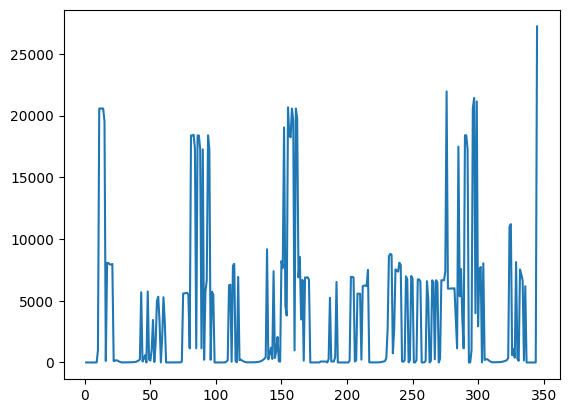

In [38]:
df_ball_positions['distance'][1:].plot()

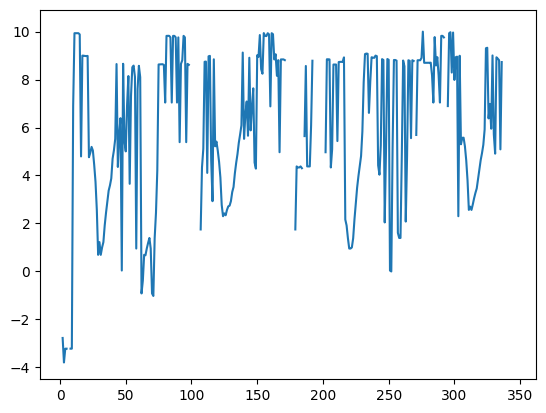

In [41]:
plt.plot(np.log(df_ball_positions['distance'][1:]))

In [67]:
df_ball_positions['distance'][1:].quantile(0.95)

18408.40000000001

In [40]:
df_ball_positions[df_ball_positions['distance'] > 18408]

,x,y,y_ma,x_ma,delta_y,ball_hit,delta_x,y_ma_shifted,x_ma_shifted,distance
0,707.0,333.0,333.0,707.0,0.0,0,0.0,333.0,0.0,499849.00
11,7.0,177.0,302.0,566.8,-31.4,0,-140.0,270.8,706.8,20573.44
12,7.0,177.0,270.8,426.8,-31.2,0,-140.0,239.4,566.8,20585.96
13,7.0,177.0,239.4,286.8,-31.4,0,-140.0,208.2,426.8,20573.44
14,7.0,177.0,208.2,146.8,-31.2,0,-140.0,177.0,286.8,20573.44
15,7.0,177.0,177.0,7.0,-31.2,0,-139.8,177.0,146.8,19544.04
81,706.0,334.0,198.8,180.4,33.8,0,131.4,232.4,49.0,18394.92
82,706.0,333.0,232.4,311.8,33.6,0,131.4,266.0,180.4,18394.92
83,707.0,333.0,266.0,443.4,33.6,0,131.6,299.6,311.8,18447.52
84,707.0,333.0,299.6,575.0,33.6,0,131.6,299.6,443.4,17318.56


In [56]:
df_ball_positions['x'] = np.where(df_ball_positions['distance'] < 15000, df_ball_positions['x'].values, np.NaN)
df_ball_positions['y'] = np.where(df_ball_positions['distance'] < 15000, df_ball_positions['y'].values, np.NaN)
df_ball_positions[['x', 'y']].isna().sum()

x    33
y    33
dtype: int64

In [57]:
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()
df_ball_positions[['x', 'y']].isna().sum()

x    0
y    0
dtype: int64

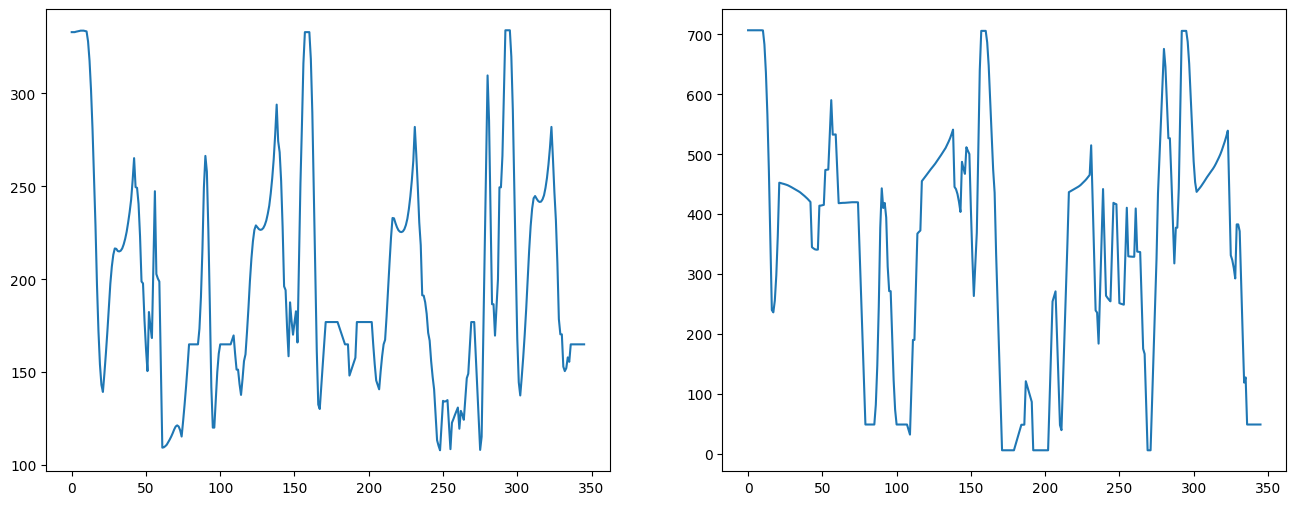

In [61]:
# MA 
df_ball_positions['y_ma'] = df_ball_positions['y'].rolling(window=5, min_periods=1, center=False).mean()
df_ball_positions['x_ma'] = df_ball_positions['x'].rolling(window=5, min_periods=1, center=False).mean()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(df_ball_positions['y_ma'])
plt.subplot(1, 2, 2)
plt.plot(df_ball_positions['x_ma'])

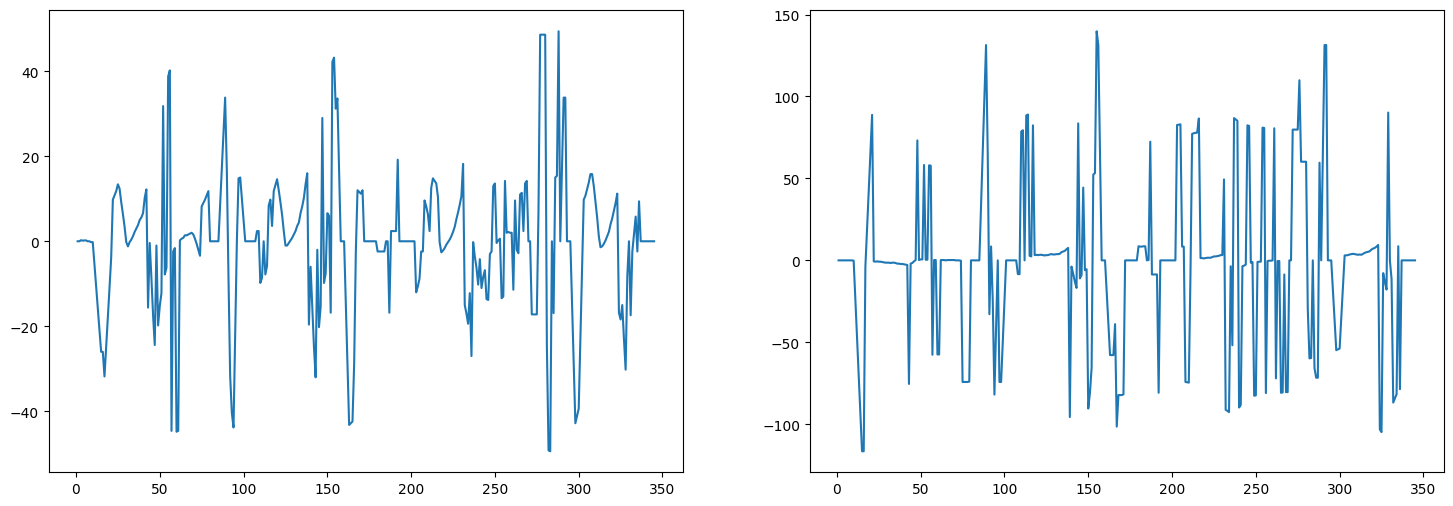

In [62]:
df_ball_positions['delta_y'] = df_ball_positions['y_ma'].diff()
df_ball_positions['delta_x'] = df_ball_positions['x_ma'].diff()


plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(df_ball_positions['delta_y'])
plt.subplot(1, 2, 2)
plt.plot(df_ball_positions['delta_x'])

In [63]:
df_ball_positions['ball_hit'] = 0


minimum_change_frames_for_hit = 25

for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count > minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1


frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x,y,y_ma,x_ma,delta_y,ball_hit,delta_x,y_ma_shifted,x_ma_shifted,distance,x_norm,y_norm


In [60]:
np.clip()

TypeError: clip() missing 3 required positional arguments: 'a', 'a_min', and 'a_max'

## Second type of ball bounce prediction

In [11]:
from src.scripts import BounceDetector

/home/suetin/Projects/VSCode/TennisApp/MainApp/TennisApp


In [12]:
bounce_detector = BounceDetector('./models/ctb_regr_bounce.cbm')  # 
bounce_detector.model

In [13]:
type(ball_positions)

list

In [14]:
ball_positions = np.array(ball_positions)
ball_positions.shape

(346, 2)

In [15]:
x, y = bounce_detector.smooth_predictions(ball_positions[:, 0], ball_positions[:, 1])
x, y

(array([707, 707, 707, 707, 707, 707, 707, 707, 707, 707, 706,   7,   7,   7,   7,   7,   7, 454, 454, 452, 452, 451, 451, 450, 449, 448, 447, 446, 444, 442, 441, 440, 438, 437, 435, 433, 430, 428, 426, 424, 421, 417, 414,  49, 414, 413, 414, 415, 415, 415, 416, 417, 706, 417, 417, 706, 706, 418, 418, 418, 419, 419,
        419, 419, 419, 419, 420, 420, 420, 420, 420, 420, 420, 420, 419,  49,  49,  49,  49,  49,  49, 706, 706, 707, 707,  49,  49,  49,  49, 706, 706,  49, 420, 420,  49,  49,  49,  49,  49,  49,  49,  49,  49,  49,  49,  49,  49,  49,   7,   7, 442, 446,  49, 449, 452, 456, 458, 461, 465, 469, 472, 475, 478, 481,
        484, 488, 491, 496, 500, 502, 506, 510, 515, 520, 527, 533, 539, 549, 558,  49, 514, 498, 484, 474, 467, 459, 453, 706, 444, 440,   7,  49,  49, 706, 706, 706, 706, 706,   6,   6, 706,   6,   6, 417, 417, 417, 415,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,  49,  48,  48,  49,  49,  49,
         49, 410,   6,   6,   6,   6,   6,   6

In [16]:
df, feats = bounce_detector.prepare_features(x, y)
df

,x_diff_1,x_diff_2,x_diff_inv_1,x_diff_inv_2,x_div_1,x_div_2,y_diff_1,y_diff_2,y_diff_inv_1,y_diff_inv_2,y_div_1,y_div_2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000e+00,0.000000e+00
3,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.000000e+15,-1.000000e+15
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.000000e+00,-1.000000e+15
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.000000e+00,-0.000000e+00
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00


In [17]:
bounce_detector.model.predict(df)

array([ -0.0027106,    0.062939,      0.1014,    0.067255,  -0.0012336,    0.017612,    0.058535,   -0.082171,    0.032933,   -0.085149,    0.046812,   0.0034475,   0.0034475,   -0.019534,    0.029651,    -0.17658,   -0.093484,    0.003704,  -0.0049152,   0.0054116,   0.0014211,   0.0090102,    0.049764,     0.42476,
           0.45634,      0.1031,    0.010983,   0.0036663,   0.0041226,     0.01169,   -0.000746,   0.0026991,    0.003813,   0.0071434,   0.0049352, -0.00012231,   0.0070249,   0.0072032,   0.0013343,    -0.10116,     0.18717,   0.0015926,  -0.0084432,     0.23354,   -0.007975,  -0.0048191,   0.0088348,   0.0040801,
         -0.030984,  0.00095014,    0.084313,    -0.10217,  -0.0062304,     0.14209,     0.28674,    -0.06921,     0.08137,   0.0095721,  -0.0035211,   0.0026854, -0.00096617,   0.0092618,   0.0075031,   -0.011255,   0.0055573,    0.008451,  -0.0041273,     0.23216,     0.24893,    0.099731,    0.016558,   -0.028019,
         -0.031189,     0.38891,     0.6965

In [18]:
ball_bounced = bounce_detector.predict(ball_positions[:, 0], ball_positions[:, 1], smooth=False)
ball_bounced

[26,
 76,
 82,
 95,
 112,
 120,
 154,
 168,
 189,
 207,
 213,
 266,
 277,
 285,
 289,
 308,
 333]